# Convert SnowMIP forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: phd_v3
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

## Col de Porte site (FR-Cdp)

**5.4 Col de Porte, France**

Grassy meadow bordered by coniferous forest. Soils are 30% clay, 60% sand and 10% silt.

**Table 5.4: Col de Porte site characteristics**

| Short name | cdp |
|:-----------|:----|
| Location | 45.30ºN, 5.77ºE |
| Elevation | 1325 m |
| Snow-free albedo | 0.2 |
| Simulation period | 1 October 1994 to 30 September 2014 |
| Temperature/humidity measurement height | 1.5 m above the snow surface |
| Wind measurement height | 10 m |
| Reference | Morin et al. (2012) |

In [2]:
site_CLASSIC = 'FR-Cdp'
site_SnowMIP = 'cdp'

year_start = '1994'
year_end = '2014'

lat = 45.30
lon = 5.77

path = '/home/lalandmi/Dropbox/data/SnowMIP/forcing'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site_CLASSIC
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site_CLASSIC+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/FR-Cdp already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/FR-Cdp/forcing has been created!


### Open original forcing file

In [3]:
ds = xr.open_dataset(path+'/met_insitu_'+site_SnowMIP+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 175320)
Coordinates:
  * time     (time) datetime64[ns] 1994-10-01T01:00:00 ... 2014-10-01
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

In [4]:
ds.time.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1048576,),
 'source': '/home/lalandmi/Dropbox/data/SnowMIP/forcing/met_insitu_cdp_1994_2014.nc',
 'original_shape': (175320,),
 'dtype': dtype('float32'),
 'units': 'hours since 1900-01-01 00:00:00.0'}

In [21]:
# Check if there are leap years
ds.sel(time='2004-02')

<xarray.Dataset>
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 2004-02-01 ... 2004-02-29T23:00:00
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

### Slice file to full years (as CLASSIC expect only full years)
It is not required as long as you only use the full years in the job file

In [6]:
year_start_full = str(int(year_start) + 1)
year_end_full = str(int(year_end) - 1)

ds_subset = ds.sel(time=slice(year_start_full, year_end_full))
ds_subset

<xarray.Dataset>
Dimensions:  (time: 166560)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 ... 2013-12-31T23:00:00
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

In [21]:
ds_subset.to_netcdf(path_tmp+'/met_insitu_'+site_SnowMIP+'_'+year_start_full+'_'+year_end_full+'.nc')

### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [22]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site_SnowMIP}_{year_start_full}_{year_end_full}.nc {path_tmp}/met_insitu_{site_SnowMIP}_{year_start_full}_{year_end_full}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 1332480 values from 8 variables over 166560 timesteps [21.40s 449MB]


## Open the new file with absolute time

In [58]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site_SnowMIP+'_'+year_start_full+'_'+year_end_full+'_a.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 166560)
Coordinates:
  * time     (time) float64 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 10 15:08:55 2023: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [31]:
ds.time

<xarray.DataArray 'time' (time: 166560)>
array([19950101.      , 19950101.041667, 19950101.083333, ..., 20131231.875   ,
       20131231.916667, 20131231.958333])
Coordinates:
  * time     (time) float64 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Example for Col de Porte -> Location: 45.30ºN, 5.77ºE

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [59]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 166560)
Coordinates:
  * time     (time) float64 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon      (lon) float64 5.77
  * lat      (lat) float64 45.3
Data variables:
    LWdown   (time, lat, lon) float32 308.3 309.2 309.2 ... 261.4 303.9 309.7
    Psurf    (time, lat, lon) float32 86382.69 86382.69 ... 86382.69 86382.69
    Qair     (time, lat, lon) float32 0.004270275 0.0042083035 ... 0.0039167013
    Rainf    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float32 0.00041666668 ... 0.0009222222
    SWdown   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair     (time, lat, lon) float32 272.85 272.65 272.45 ... 271.75 271.95
    Wind     (time, lat, lon) float32 0.7 0.5 0.5 0.8 0.6 ... 1.2 1.8 1.5 1.6
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 10 15:08:55 2023: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

### Convert temperature to °C (<mark>required by CLASSIC</mark>)

In [60]:
with xr.set_options(keep_attrs=True):
    ds['Tair'] = ds['Tair'] - 273.15
    ds.Tair.attrs['units'] = '°C'
ds.Tair

<xarray.DataArray 'Tair' (time: 166560, lat: 1, lon: 1)>
array([[[-0.2999878]],

       [[-0.5      ]],

       [[-0.6999817]],

       ...,

       [[-1.7999878]],

       [[-1.3999939]],

       [[-1.1999817]]], dtype=float32)
Coordinates:
  * time     (time) float64 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon      (lon) float64 5.77
  * lat      (lat) float64 45.3
Attributes:
    long_name:  Near-surface air temperature
    units:      °C
    ALMA_name:  Tair
    CMIP_name:  ta

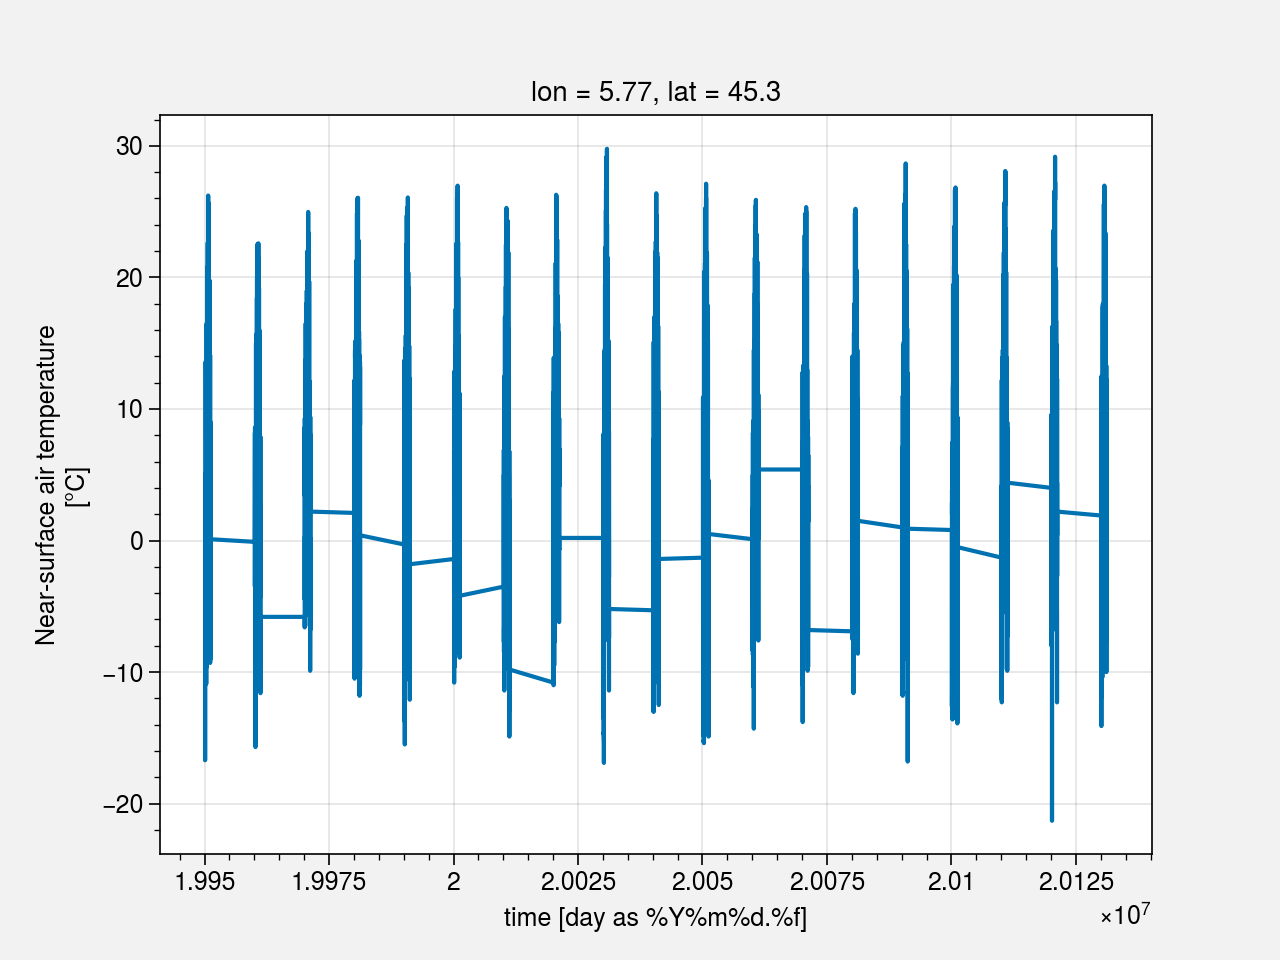

In [10]:
ds.Tair.plot()

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

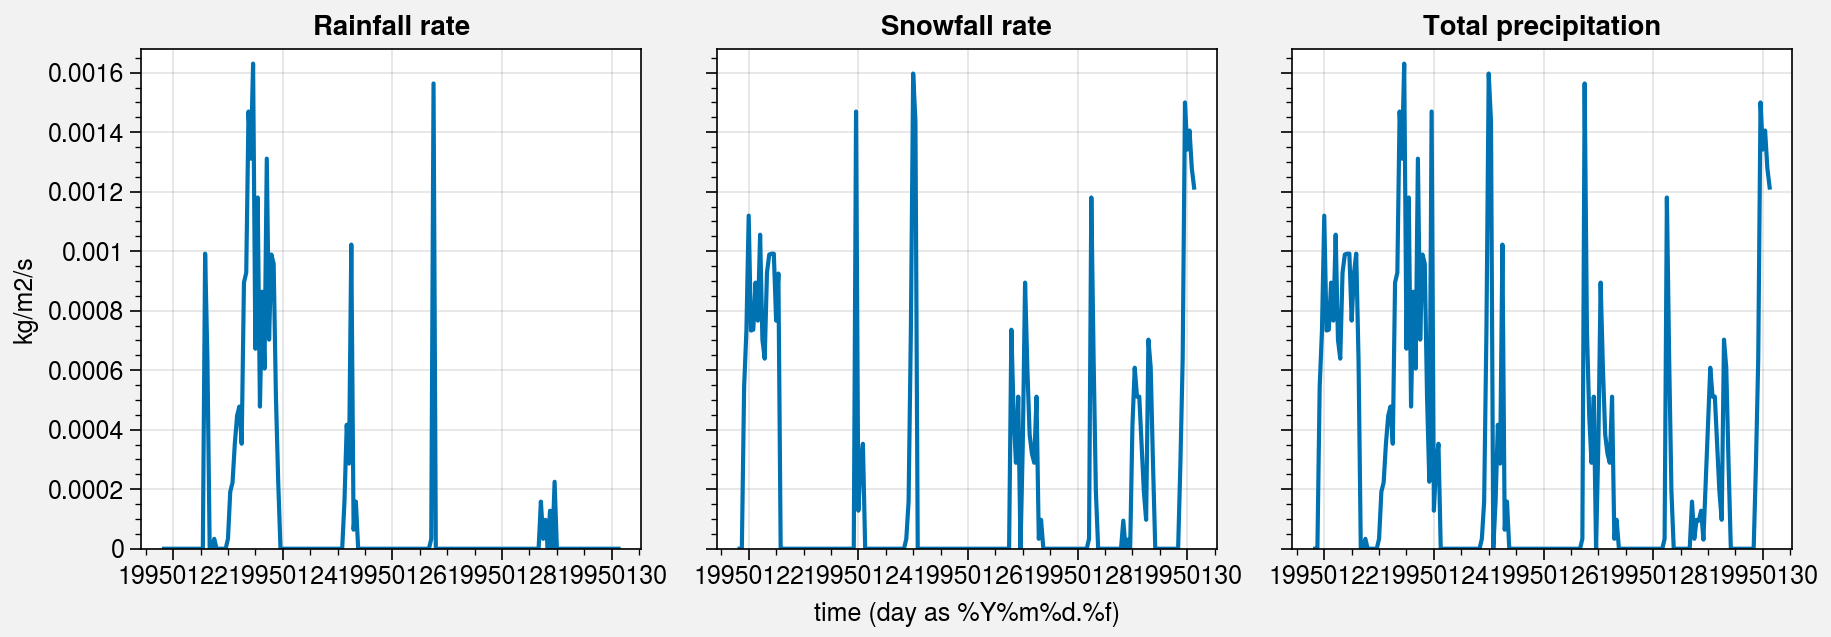

In [61]:
fig, axs = plot.subplots(ncols=3, nrows=1)

i_start = 500
i_end = 700

axs[0].plot(ds.Rainf[i_start:i_end])
axs[1].plot(ds.Snowf[i_start:i_end])
axs[2].plot(ds.Rainf[i_start:i_end] + ds.Snowf[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf[i_start:i_end] + ds.Snowf[i_start:i_end]).values.item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [62]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset>
Dimensions:    (lat: 1, lon: 1, time: 166560)
Coordinates:
  * time       (time) float64 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon        (lon) float64 5.77
  * lat        (lat) float64 45.3
Data variables:
    LWdown     (time, lat, lon) float32 308.3 309.2 309.2 ... 261.4 303.9 309.7
    Psurf      (time, lat, lon) float32 86382.69 86382.69 ... 86382.69 86382.69
    Qair       (time, lat, lon) float32 0.004270275 ... 0.0039167013
    Rainf      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float32 0.00041666668 ... 0.0009222222
    SWdown     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair       (time, lat, lon) float32 -0.2999878 -0.5 ... -1.1999817
    Wind       (time, lat, lon) float32 0.7 0.5 0.5 0.8 0.6 ... 1.2 1.8 1.5 1.6
    TotPrecip  (time, lat, lon) float32 0.00041666668 ... 0.0009222222
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 10 15:08:55 2023: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [63]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site_SnowMIP+'_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site_SnowMIP+'_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')

In [64]:
!ls {path_out}

met_insitu_cdp_1995_2013_LWdown.nc  met_insitu_cdp_1995_2013_SWdown.nc
met_insitu_cdp_1995_2013_Psurf.nc   met_insitu_cdp_1995_2013_Tair.nc
met_insitu_cdp_1995_2013_Qair.nc    met_insitu_cdp_1995_2013_TotPrecip.nc
met_insitu_cdp_1995_2013_Rainf.nc   met_insitu_cdp_1995_2013_Wind.nc
met_insitu_cdp_1995_2013_Snowf.nc


In [65]:
!ls {path_out_CLASSIC}

met_insitu_cdp_1995_2013_LWdown.nc  met_insitu_cdp_1995_2013_SWdown.nc
met_insitu_cdp_1995_2013_Psurf.nc   met_insitu_cdp_1995_2013_Tair.nc
met_insitu_cdp_1995_2013_Qair.nc    met_insitu_cdp_1995_2013_TotPrecip.nc
met_insitu_cdp_1995_2013_Rainf.nc   met_insitu_cdp_1995_2013_Wind.nc
met_insitu_cdp_1995_2013_Snowf.nc


### Convert time dimension to UNLIMITED (not required by CLASSIC)

In [47]:
#for key in list(ds.keys()):
#    !ncks --mk_rec_dmn time input_file.nc -o output_file.nc

In [48]:
#!ncdump -h output_file.nc